# Regression linéaire avec les moindres carrés

In [35]:
% matplotlib inline
from __future__ import print_function
from numpy import array, zeros, zeros_like, ones, vstack, mod, loadtxt, linspace, logspace, mean, atleast_2d, ravel
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import pinv

In [ ]:
cd src/notebook/coursMLpython/

## Introduction et notations

Soit une collection de $m$ exemples $\{x^{(i)}\}_{i=1}^m$ dans $\mathcal{X} \subseteq \mathbb{R}^n$, où $n$ est le nombre de _features_ de chaque exemple. On cherche à prédire une valeur $y^{(i)}$ de $\mathcal{Y} \subseteq \mathbb{R}$ associée à chaque exemple, en se restreignant aux solutions linéaires, c'est-à-dire telle que notre hypothèse est du type $y^{(i)} = h(x^{(i)})$ avec 

$$h_{\theta}(x) = \sum_{i=0}^n \theta_i x_i = \theta^T X$$

Ceci qui peut s'écrire :

In [2]:
def h(theta, x):
    h_predit = 0.
    for i in range(len(x)):
        h_predit += theta[i]*x[i]
    return h_predit

Ou sous forme matricielle, plus optimisée :

In [3]:
def h(theta, X):
    # print (type(theta), len(theta) )
    return theta.dot(X) # theta'*X en matlab

Vous pourrez remarquer que le produit scalaire s'écrit un peu différemment en Python et en Matlab. 

La méthode des moindres carrés consiste à réduire l'erreur quadratique. Nous choisissons donc la fonction de coût suivante :

$$J(\theta) = \frac{1}{2}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 $$

In [4]:
def J(theta, X, Y):
    J = 0.
    for i, (x_i, y_i) in enumerate(zip(X, Y)):
        J += (h(theta, x_i) - y_i)**2
    return 1/2.*J

On préfèrera également la version matricielle : 
$$J(\theta) = \frac{1}{2m}(X^T\theta - y)^T(X^T\theta - y)$$

In [5]:
def J(theta, X, Y):
    return 1/(2.*m)*(X.dot(theta) - Y).T.dot(X.dot(theta) - Y)

## Minimisation de l'erreur par descente de gradient

Pour minimiser $J(\theta)$, nous allons effectuer une descente de gradient, c'est-à-dire initialiser $\theta$ puis le mettre à jour avec :

$$\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial\theta_j}$$

La dérivée partielle de $J(\theta)$ est équivalente à $(h_\theta(x)-y)x_j$. On peut implémenter une version *batch* ou une version stochastique de la descente de gradient pour résoudre ce problème. 

### Descente de gradient en mode *batch*

La version *batch* consiste à mettre à jour la valeur de $\theta$ avec le gradient calculé sur l'ensemble des exemples. L'algorithme s'écrit :

Répéter jusqu'à convergence:

$$\theta_j := \theta_j + \frac{\alpha}{m} \sum_{i=1}^{m}(y^{(i)}-h_\theta(x^{(i)}))x^{(i)}_j$$

On peut implémenter l'algorithme *batch* de la façon suivante :

In [6]:
def batch_update(theta, X, Y, alpha=0.01):
    derivative = zeros_like(theta)
    m, n = X.shape
    for j in range(n):
        for i in range(m):
            derivative[j] += alpha * (Y[i] - h(theta, X[i,:])) * X[i,j]
    return theta + 1./m*derivative

Il est possible de réécrire cet algorithme de façon plus concise et plus efficice en utilisant une représentation matricielle :
$$\theta_j := \theta_j + \frac{\alpha}{m} (Y-X^T\theta) X$$

In [7]:
def batch_update(theta, X, Y, alpha=0.01):
    m, _ = X.shape
    return theta + (alpha/m)* (Y-X.dot(theta)).dot(X)

### Descente de gradient stochastique

Il est également possible d'utiliser une version stochastique de la descente de gradient. Dans ce cas l'algorithme est mis à jour après chaque exemple, ce qui accèlere considérablement la convergence. Cependant l'algorithme *batch* converge de façon certaine vers l'optimum, qui est unique et global dans notre cas, alors que la version stochastique ne permet que de s'en approcher. L'algorithme stochastique s'écrit:

Répéter jusqu'à convergence:

Pour $i$ de 1 à $m$:

$\theta_j := \theta_j + \alpha (y^{(i)} - h_\theta (x^{(i)}) ) x^{(i)}_j $

In [8]:
def stochastic_update(theta, X, Y, alpha=0.01):
    new_theta = theta.copy()
    m = X.shape[0]
    for i in range(m):
        new_theta += alpha * (Y[i] - X[i,:].dot(theta)) * X[i,:]
    return new_theta

Une version qui utilise les idiomes Python ressemblerait à :

In [9]:
def stochastic_update(theta, X, Y, alpha=0.01):
    new_theta = theta.copy()
    m = X.shape[0]
    for i, (x_i, y_i) in enumerate(zip(X,Y)):
        new_theta += alpha * (y_i - x_i.dot(theta)) * x_i
    return new_theta

### Solution explicite des moindres carrés

Il est également possible de dériver directement une solution qui minimise les moindres carrés:

\begin{equation}
\begin{split}
\nabla_\theta J(\theta) & = \nabla_\theta \frac{1}{2}(X\theta - y)^T(X\theta - y)\\
& = X^T X \theta - X^T y
\end{split}
\end{equation}

Pour trouver le minimum, on cherche le point om la dérivée s'annule:

$$ X^T X \theta = X^T y$$

et on ferme l'équation pour obtenir la valeur de $\theta$ qui minimise $J(\theta)$:

$$ \theta = (X^T X)^{-1} X^T y $$

Il est ainsi possible de calculer directement la valeur optimale de $\theta$ sans avoir besoin d'itérer une descente de gradient. Par contre cette solution requiert l'inversion d'une matrice, ce qui n'est envisageable que si la taille de $X$ est raisonnable (pas plus d'un millier d'échantillon). L'algorithme est le suivant:

In [10]:
def normal_equation(X, Y):
    return pinv(X.T.dot(X)).dot(X.T).dot(Y)

## Application: estimation du prix de l'immobilier dans l'Oregon

Pour appliquer la régression linaire, nous allons d'abord charger un ensemble de données qui contient des informations sur les prix de 47 maisons à Portland, dans l'Oregan. Les données indiquent deux informations : 

* la surface de la maison en pieds carrés (ft$^2$),

* le nombre de pièces

Nous disposons également du prix de vente de chaque maison. Ainsi, pour ce jeu de données $m=47$ et $n=2$, nous avons donc 47 exemples $x^{(i)}$ qui sont décrits dans $\mathbb{R}^2$ (surface et nombre de pièces) et nous essayerons de prédire le prix de la maison $y^{(i)}$.

In [11]:
data = loadtxt('house_x.dat')
Y_orig = loadtxt('house_y.dat')
n = 2
m = data.shape[0]
surface_min = 500
surface_max = 5000
prix_min = 100
prix_max = 800

print (data[0:3, :].astype(int))

[[2104    3]
 [1600    3]
 [2400    3]]


Nous allons pour l'instant nous concentrer uniquement sur les informations de surface : nous n'utiliserons pas le nombre de pièces pour prédire le prix des maisons. Ceci pour des raisons pédagogiques, car il est plus simple de visualiser des données unidimensionnelles. 

La première chose à faire est de normaliser les données de telle sorte à ce que la moyenne soit nulle et la variance unitaire.

In [12]:
X_orig = ones(shape=(m, 2))
X_orig[:,1] = data[:,0]
Y = Y_orig.copy()

X = ones(shape=(m, 2))
X_mean = data[:,0].mean()
X_std = data[:,0].std()
X[:,1] = (data[:,0] - X_mean) / X_std

Y_mean = Y.mean()
Y_std = Y.std()
Y = (Y - Y_mean) / Y_std

Nous allons définir les fonctions qui vont nous permettre de faire les affichages et les tester :

In [13]:
def plot_data(X, Y, color=None, label=None):
    X_scaled = (X * X_std) + X_mean
    Y_scaled = ((Y * Y_std) + Y_mean)/1000
    if color is not None:
        plt.plot(X_scaled, Y_scaled, color+'o', alpha=0.5, label=label)
    else:
        plt.plot(X_scaled, Y_scaled, 'ok', alpha=0.5)
    plt.xlabel(u'surface (ft$^2$)')
    plt.ylabel(u'Prix (k$)')
    plt.xlim(surface_min, surface_max)
    plt.ylim(prix_min, prix_max)
    if label is not None:
        plt.legend(loc='lower right')
        
def plot_regression(theta, color='b-', alpha=1, label=None):
    surf_min_scaled = (surface_min-X_mean)/X_std
    surf_max_scaled = (surface_max-X_mean)/X_std
    regression = array([array([1, surf_min_scaled]).dot(theta), 
                           array([1, surf_max_scaled]).dot(theta)])
    scaled_regression = ((regression * Y_std) + Y_mean)/1000
    plt.plot([surface_min, surface_max], 
             scaled_regression, 
             color, alpha=alpha, label=label)

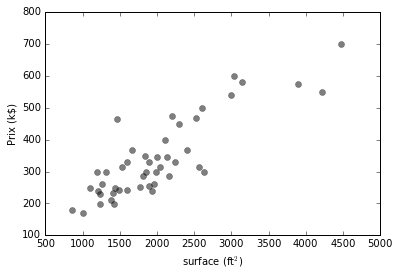

In [14]:
plot_data(X[:,1], Y)

On applique notre algorithme *batch* avec 1000 itérations successives. Les valeurs successives des régressions sont affichées en bleu et la prédiction finale est en noir : on voit que l'algorithme converge doucement tout au long des itérations.

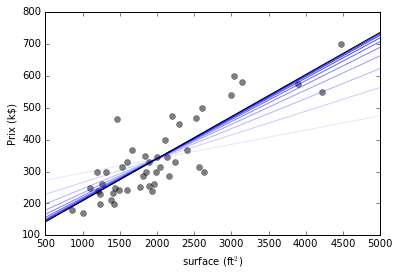

In [15]:
plot_data(X[:,1], Y)
theta_batch = zeros(n)
alpha = 0.005  
iteration = 800
J_batch = zeros(iteration)
for i in range(iteration):
    theta_batch = batch_update(theta_batch, X, Y, alpha)
    J_batch[i] =  J(theta_batch, X, Y)
    if (mod(i, iteration/10) == 0):
        plot_regression(theta_batch, 'b-', alpha=float(i)/iteration)
plot_regression(theta_batch, 'k-')    

On cherche maintenant à effectuer une régression linéaire avec l'algorithme stochastique. Dans ce cas, les prédictions au cours des itérations sont en rouge et la régression finale est en noir. L'algorithme converge extrêmement vite et est stabilisé après 100 itérations sur les 1000 effectuées.

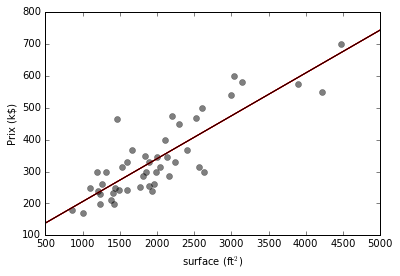

In [16]:
plot_data(X[:,1], Y)
theta_stoch = zeros(n)
alpha = 0.005
iteration = 800
J_stochastic = zeros(iteration)
for i in range(iteration):
    theta_stoch = stochastic_update(theta_stoch, X, Y, alpha)
    J_stochastic[i] =  J(theta_stoch, X, Y)
    if (mod(i, iteration/10) == 0):        
        plot_regression(theta_stoch, 'r-', alpha=float(i)/iteration)
plot_regression(theta_stoch, 'k-')   

Les algorithmes convergent à des vitesses différentes, la version stochastique étant plus rapide car en une itération $\theta$ est mis à jour $m$ fois. Il est possible de comparer la vitesse de convergence en affichant la valeur de l'erreur quadratique $J(\theta)$ calculée à chaque itération. On voit que l'algorithme *batch* n'a pas fini de converger après 1000 itérations alors que l'algorithme stochastique a convergé avant la 100$^e$ itération. Pour améliorer la vitesse de convergence, il est possible d'augmenter la valeur du taux d'apprentissage $\alpha$ (*learning rate*).

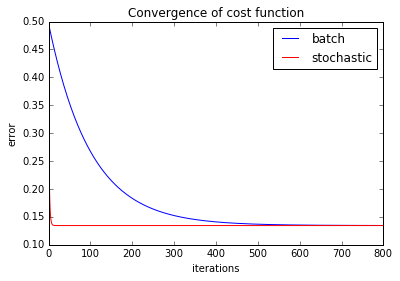

In [17]:
f = plt.plot(J_batch, 'b', label='batch')
g = plt.plot(J_stochastic, 'r', label='stochastic')
plt.title('Convergence of cost function')
plt.xlabel('iterations')
plt.ylabel('error')
_ = plt.legend()    

Il est également possible de calculer directement la valeur de $\theta$ avec la solution explicite des moindres carrés. Il n'est pas nécessaire dans ce cas d'itérer l'algorithme : on obtient immédiatement la valeur optimale.

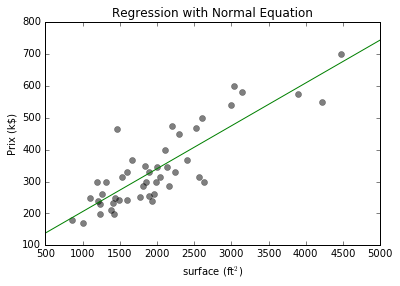

In [18]:
plot_data(X[:,1], Y)
theta_normal = normal_equation(X, Y)
plot_regression(theta_normal, 'g-', label='Normal equation')
_ = plt.title('Regression with Normal Equation')

Comparons maintenant les valeurs des regressions obtenues avec les 3 méthodes : la descente de gradient *batch* (bleu), la descente de gradient stochastique (rouge) et la solution explicite des moindres carrés (vert). On peut voir que la solution explicite et la méthode stochastique ont convergé vers le même optimum. La méthode *batch* n'a pas réussi à atteindre l'optimum après 1000 itérations: il faut soit augmenter le nombre d'itérations soit choisir un taux d'apprentissage $\alpha$ plus grand.

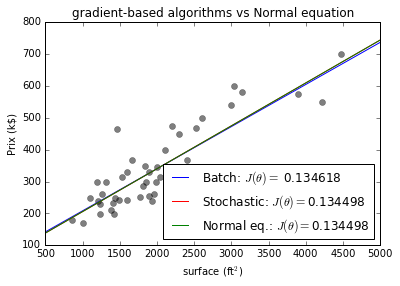

In [19]:
plot_data(X[:,1], Y)
plot_regression(theta_batch, 'b-', label=r'Batch: $J(\theta)=$ %g' % J(theta_batch, X, Y))
plot_regression(theta_stoch, 'r-', label=r'Stochastic: $J(\theta)=$%g' % J(theta_stoch, X, Y))  
plot_regression(theta_normal, 'g-', label=r'Normal eq.: $J(\theta)=$%g' % J(theta_normal, X, Y))
plt.title('gradient-based algorithms vs Normal equation')   
_ = plt.legend(loc='lower right')

Pour choisir correctement le taux d'apprentissage, il faut faire des tests. En pratique, soit $\alpha$ est suffisamment petit et l'algorithme va converger, soit $\alpha$ est trop grand et l'algorithme va rapidement diverger. Une façon simple est de vérifier la valeur de l'erreur quadratique $J(\theta)$ après quelques itérations pour différentes valeurs de $\alpha$, et d'affiner itérativement son choix.

Sur le graphique ci dessous, on peut voir que la vitesse de convergence de l'algorithme s'accroit jusqu'à $\alpha=0.5$ où elle atteint un plateau. Au delà de $\alpha=2$, l'algorithme commence à diverger: les valeurs de $J(\theta)$ pour $\alpha > 2$ ne sont pas représentées car elles sont très grandes (supérieure à $10^9$), voire dépassent la précision machine (aboutissant à  des NaN).

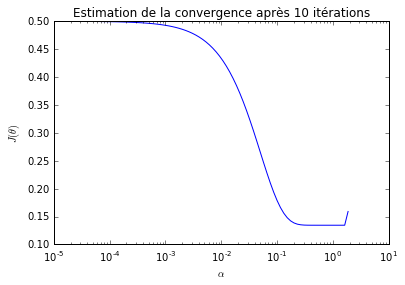

In [20]:
iterations = 10
alpha = logspace(-5, 1, 100)
J_conv = zeros(len(alpha))
for i, a in enumerate(alpha):
    theta = zeros(n)
    for t in range(iterations):
        theta = batch_update(theta, X, Y, a)
    J_conv[i] = J(theta, X, Y)
plt.figure()
plt.plot(alpha[:88], J_conv[:88]) 
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$J(\theta)$')
plt.title(u'Estimation de la convergence après 10 itérations')
plt.xscale('log')

### Visualisation de la descente du gradient

Nous allons maintenant voir la forme du gradient. Pour cela, nous allons calculer la valeur de $J(\theta)$ pour différents $\theta$ et afficher le résultat. Les valeurs de $\theta_0$ sont en abscisse et les valeurs de $\theta_1$ en ordonnée, le plan est coloré en fonction de la valeur de $J(\theta)$. Comme $J(\theta)$ est l'erreur quadratique, il y a un minimum global, qui est indiqué par un point en noir, c'est la valeur trouvée par notre descente de gradient.

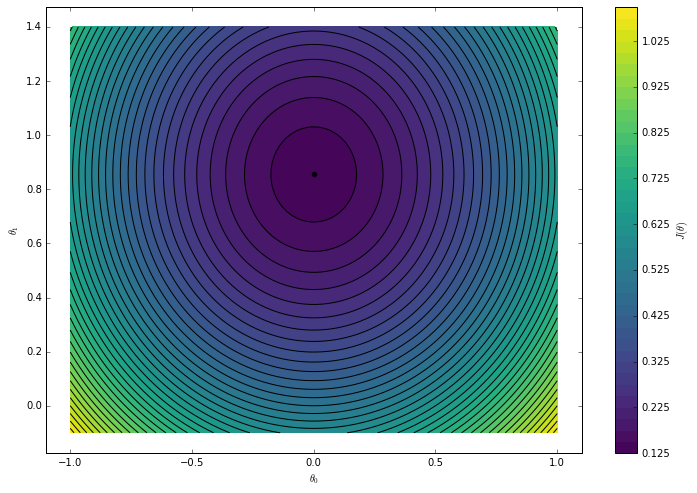

In [25]:
theta0_vals = linspace(-1, 1, 100)
theta1_vals = linspace(-0.1, 1.4, 100)
J_vals = zeros(shape=(theta0_vals.size, theta1_vals.size))
for t1, theta0 in enumerate(theta0_vals):
    for t2, theta1 in enumerate(theta1_vals):
        J_vals[t1, t2] = J(array([theta0, theta1]), X, Y)
J_vals = J_vals.T

def plot_gradient(theta0_vals, theta1_vals, Z):
    levels = logspace(2, 8, 40)
    plt.set_cmap(cm.viridis)
    plt.contourf(theta0_vals, theta1_vals, Z, 40)
    cbar = plt.colorbar()
    cbar.set_label(r'$J(\theta)$')
    v = plt.axis()
    plt.contour(theta0_vals, theta1_vals, Z, 40, hold=True, colors='k')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')

plt.rcParams["figure.figsize"]=[12., 8.]
plot_gradient(theta0_vals, theta1_vals, J_vals)
_ = plt.scatter(theta_stoch[0], theta_stoch[1], c='k')

Il est possible de visualiser la descente de gradient en affichant le point de démarrage de l'algorithme $\theta = (0,0)$ avec un point noir et de tracer les points qui indiquent les valeurs prises successivement par $\theta$ au fur et à mesure des itérations. Regardons comment l'algorithme de descente de gradient *batch* converge:

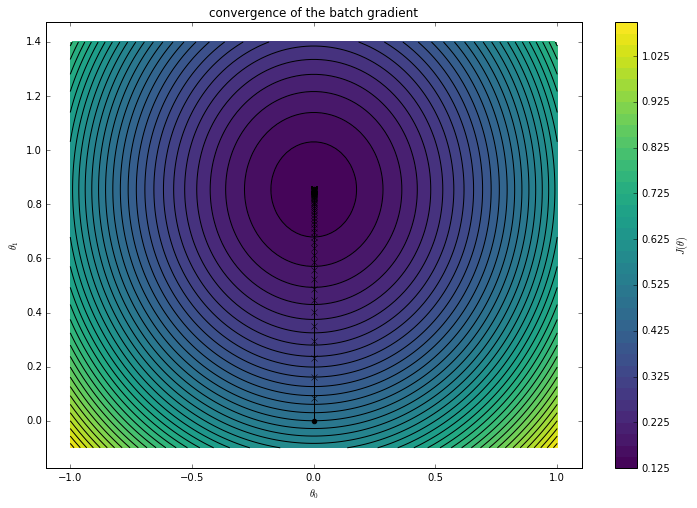

In [26]:
plot_gradient(theta0_vals, theta1_vals, J_vals)

alpha = 0.1
iteration = 1000
t_batch = zeros(shape=(iteration, 2))
for i in range(iteration):
    t_batch[i,:] = batch_update(t_batch[i-1,:], X, Y, alpha)
plt.plot([0, 0], t_batch[-1,:], c='k')
plt.plot(t_batch[:,0], t_batch[:,1], 'xk')
plt.scatter(0, 0, c='k')
plt.scatter(t_batch[-1,0], t_batch[-1,1], c='k')
_ = plt.title('convergence of the batch gradient')

Comparons maintenant avec l'algorithme de descente de gradient stochastique. On voit que la convergence est beaucoup plus rapide : le gradient "saute" beaucoup plus vite vers le centre bien que la valeur de $\alpha$ soit identique en *batch* et en stochastique.

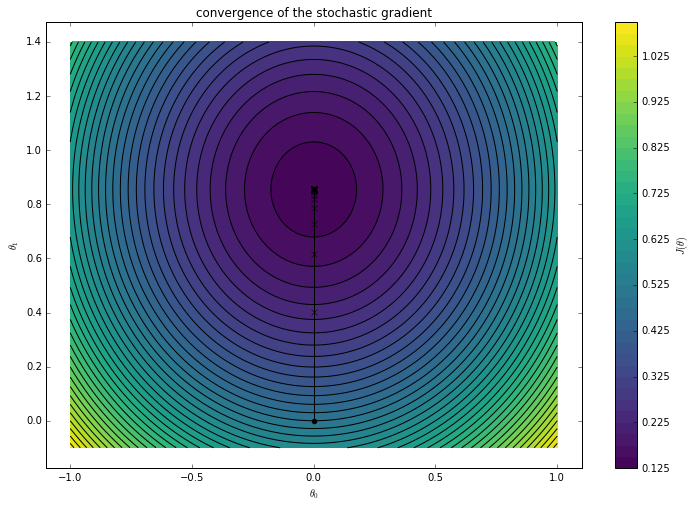

In [27]:
plot_gradient(theta0_vals, theta1_vals, J_vals)

alpha = 0.01
iteration = 1000
t_stoch = zeros(shape=(iteration, 2))
for i in range(iteration):
    t_stoch[i,:] = stochastic_update(t_stoch[i-1,:], X, Y, alpha)
plt.plot([0, 0], t_batch[-1,:], c='k')
plt.plot(t_stoch[:,0], t_stoch[:,1], 'xk')
plt.scatter(0, 0, c='k')
plt.scatter(t_stoch[-1,0], t_stoch[-1,1], c='k')
_ = plt.title('convergence of the stochastic gradient')

## Un maximum d'efficacité avec scikit-learn

Il n'est pas nécessaire de réinventer la roue, tous les algorithmes que nous avons vu ont été implémentés et vérifiés par une large communauté de programmeurs. C'est même la devise de Python, "Batteries included", car il y a des bibliothèques pour tous les problèmes possibles.

Nous allons regarder comment utiliser ces algorithmes avec la bibliothèque scikit-learn (appelée sklearn). Commençons par la régression en utilisant la solution explicite des moindres carrés.

Nous allons utiliser le StandardScaler qui permet de centrer les données et LinearRegression pour calculer la regression linéaire.

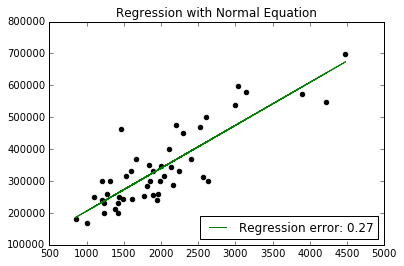

In [30]:
from sklearn import linear_model, preprocessing

data = loadtxt('house_x.dat')
Y_orig = loadtxt('house_y.dat').reshape(-1,1)

# Scaling data
Xscaler = preprocessing.StandardScaler().fit(data[:,0].reshape(-1,1))
X = atleast_2d(Xscaler.transform(data[:,0].reshape(-1,1)))
Yscaler = preprocessing.StandardScaler().fit(Y_orig)
Y = Yscaler.transform(Y_orig)

# regression with Normal equation
regression = linear_model.LinearRegression(fit_intercept=True).fit(X, Y) #(data, Y_orig)

plt.rcParams["figure.figsize"]=[6., 4.]
plt.scatter(Xscaler.inverse_transform(X), Yscaler.inverse_transform(Y), c='black')
plt.plot(Xscaler.inverse_transform(X), Yscaler.inverse_transform(regression.predict(X)), 
     color='green', label="Regression error: %.2f" % mean((regression.predict(X) - Y) ** 2))
plt.title('Regression with Normal Equation')
_ = plt.legend(loc='lower right')

Scikit-learn propose une implémentation efficace de la descente de gradient stochastique:

In [33]:
from sklearn.linear_model import SGDRegressor

stochastic_descent = SGDRegressor(alpha=0.01, n_iter=100).fit(X, ravel(Y))

plt.scatter(Xscaler.inverse_transform(X), Yscaler.inverse_transform(Y), c='black')
plt.plot(Xscaler.inverse_transform(X), 
         Yscaler.inverse_transform(stochastic_descent.predict(X)), 
         color='red', 
         label="Regression error: %.2f" % mean((stochastic_descent.predict(X) - Y) ** 2))
plt.title('Regression with SGD')
_ = plt.legend(loc='lower right')

NameError: name 'ravel' is not defined

La bibliothèque scikit-learn propose des implémentations performantes et faciles à utiliser des principaux algorithmes d'apprentissage automatique. Il est ainsi possible d'appliquer des normalisations et des traitements usuels sur les données en quelques lignes de calculs. Du point de vue performance, scikit-learn propose quand c'est possible des implémentations multiprocessus.